In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms 

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import tqdm 

In [2]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'mps'

# 데이터 불러오기

In [3]:
cifar100 = torchvision.datasets.CIFAR100(root='./data', 
                                         train=True, 
                                         download=True)
										 

Files already downloaded and verified


In [4]:
len(cifar100.targets)

50000

In [5]:
dataset = cifar100.data[:]
target = cifar100.targets[:]


# 데이터 분할하기

In [6]:
# 7 : 1.5 : 1.5

trn_x, test_x, trn_y, test_y = train_test_split(dataset, target, test_size=0.3)
val_x, tst_x, val_y, tst_y = train_test_split(test_x, test_y, test_size=0.5)

In [7]:
len(trn_y), len(val_y), len(tst_y)

(35000, 7500, 7500)

In [8]:
trn_x.shape

(35000, 32, 32, 3)

# 데이터 전처리

In [9]:
from torchvision import transforms

train_transform = transforms.Compose([
#     transforms.Resize((32, 32)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762)),
])

test_transform = transforms.Compose([
#     transforms.Resize(32, 32),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762)),
])

# 데이터셋 & 데이터 로더 생성 

In [10]:
from PIL import Image

class custom_dataset(torch.utils.data.Dataset):
    def __init__(self, x, y, transform):
        self.transform = transform
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        # numpy 배열을 PIL 이미지로 변환
        x = Image.fromarray(self.x[index])
        # 변환 적용
        x = self.transform(x)
        y = self.y[index]
        
        return x, y

In [11]:
trn_ds = custom_dataset(trn_x, trn_y, train_transform)
val_ds = custom_dataset(val_x, val_y, test_transform)
tst_ds = custom_dataset(tst_x, tst_y, test_transform)

In [29]:
batch_size = 64
train_dataloader = torch.utils.data.DataLoader(trn_ds, batch_size=batch_size, shuffle=True)
validation_dataloader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(tst_ds, batch_size=batch_size)

# 모델 구성

In [30]:
for x, y in train_dataloader:
    print(x.shape, y.shape)
    break

torch.Size([64, 3, 32, 32]) torch.Size([64])


In [95]:
class cnn(nn.Module):
	def __init__(self):
		super(cnn, self).__init__()
		self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
		self.conv2 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
		self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
		self.relu = nn.ReLU()
		self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
		self.linear = nn.Linear(4 * 4 * 32, 100)
		self.dropout = nn.Dropout(0.2)
		self.bn32 = nn.BatchNorm2d(32)
		self.bn64 = nn.BatchNorm2d(64)
		self.bn128 = nn.BatchNorm2d(128)
		
	def forward(self, x):
		x = self.conv1(x)
		x = self.bn64(x)
		x = self.relu(x)
		x = self.pool(x)
	
		x = self.conv2(x)
		x = self.bn32(x)
		x = self.relu(x)
		x = self.pool(x)

		x = self.conv3(x)
		x = self.bn32(x)
		x = self.relu(x)
		x = self.pool(x)

		x = x.view(-1, 4 * 4 * 32)
		x = self.dropout(x)
		x = self.linear(x)
		
		return x

In [96]:
model = cnn().to(device)
print(model)

cnn(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear): Linear(in_features=512, out_features=100, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (bn32): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn64): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn128): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [97]:
from sklearn.metrics import accuracy_score


def train_validate(model, train_dataloader, test_loader, optimizer, loss_func, epochs):
	train_losses = []
	train_accs = []
	validation_losses = []
	validation_accs = []

	for epoch in range(epochs):
		epoch_train_loss = 0.0
		epoch_train_acc = 0.0
		model.train()

		# 훈련 루프
		for data, target in tqdm.tqdm(train_dataloader):

			data = data.to(device)
			target = target.to(device)
			
			pred = model(data)

			loss = criterion(pred, target)
			
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()

			correct_pred = torch.argmax(pred, 1) == target
			
			acc = accuracy_score(target.cpu(), pred.argmax(dim=1).detach().cpu())

			epoch_train_loss += loss.item()
			epoch_train_acc += acc

		# 에포크 당 평균 훈련 손실 및 정확도
		avg_train_loss = epoch_train_loss / len(train_dataloader)
		avg_train_acc = epoch_train_acc / len(train_dataloader)

		train_losses.append(avg_train_loss)
		train_accs.append(avg_train_acc)

		print(f"Epoch: {epoch+1}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}")

		# 검증 루프
		model.eval()
		epoch_validation_loss = 0.0
		with torch.no_grad():
			for data, target in tqdm.tqdm(test_loader):

				data = data.to(device)
				target = target.to(device)

				pred = model(data)

				loss = criterion(pred, target)
				
				epoch_validation_loss += loss.item()
		
		avg_validation_loss = epoch_validation_loss / len(test_loader)
		avg_validation_acc = accuracy_score(target.cpu(), pred.argmax(dim=1).detach().cpu())
		
		validation_losses.append(avg_validation_loss)
		validation_accs.append(avg_validation_acc)

		print(f"Validation Loss: {avg_validation_loss:.4f}, Validation Acc: {avg_validation_acc:.4f}")

	return train_losses, train_accs, validation_losses, validation_accs

In [98]:
epochs= 40
model = cnn().to(device)
lr = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_losses, train_accs, validation_losses, validation_accs = train_validate(model, train_dataloader, validation_dataloader, optimizer, criterion, epochs)

100%|██████████| 547/547 [00:15<00:00, 35.97it/s]


Epoch: 1, Train Loss: 3.5994, Train Acc: 0.1602


100%|██████████| 118/118 [00:01<00:00, 61.31it/s]


Validation Loss: 3.8625, Validation Acc: 0.0000


100%|██████████| 547/547 [00:18<00:00, 29.49it/s]


Epoch: 2, Train Loss: 2.8402, Train Acc: 0.2983


100%|██████████| 118/118 [00:03<00:00, 34.73it/s]


Validation Loss: 3.5328, Validation Acc: 0.0833


100%|██████████| 547/547 [00:30<00:00, 18.15it/s]


Epoch: 3, Train Loss: 2.5213, Train Acc: 0.3617


100%|██████████| 118/118 [00:01<00:00, 64.49it/s]


Validation Loss: 3.2339, Validation Acc: 0.2500


100%|██████████| 547/547 [00:19<00:00, 28.11it/s]


Epoch: 4, Train Loss: 2.3500, Train Acc: 0.3941


100%|██████████| 118/118 [00:01<00:00, 65.37it/s]


Validation Loss: 3.3506, Validation Acc: 0.2500


100%|██████████| 547/547 [00:18<00:00, 29.17it/s]


Epoch: 5, Train Loss: 2.2269, Train Acc: 0.4215


100%|██████████| 118/118 [00:02<00:00, 58.58it/s]


Validation Loss: 3.2426, Validation Acc: 0.2500


100%|██████████| 547/547 [00:18<00:00, 29.89it/s]


Epoch: 6, Train Loss: 2.1324, Train Acc: 0.4404


100%|██████████| 118/118 [00:01<00:00, 76.67it/s]


Validation Loss: 3.2074, Validation Acc: 0.0833


100%|██████████| 547/547 [00:18<00:00, 30.17it/s]


Epoch: 7, Train Loss: 2.0531, Train Acc: 0.4564


100%|██████████| 118/118 [00:01<00:00, 64.11it/s]


Validation Loss: 3.2060, Validation Acc: 0.0833


100%|██████████| 547/547 [00:18<00:00, 29.72it/s]


Epoch: 8, Train Loss: 2.0002, Train Acc: 0.4675


100%|██████████| 118/118 [00:01<00:00, 65.42it/s]


Validation Loss: 3.2333, Validation Acc: 0.0833


100%|██████████| 547/547 [00:18<00:00, 29.93it/s]


Epoch: 9, Train Loss: 1.9379, Train Acc: 0.4855


100%|██████████| 118/118 [00:01<00:00, 65.77it/s]


Validation Loss: 3.1472, Validation Acc: 0.0833


100%|██████████| 547/547 [00:17<00:00, 30.51it/s]


Epoch: 10, Train Loss: 1.8941, Train Acc: 0.4962


100%|██████████| 118/118 [00:01<00:00, 66.95it/s]


Validation Loss: 3.1098, Validation Acc: 0.0000


100%|██████████| 547/547 [00:18<00:00, 29.05it/s]


Epoch: 11, Train Loss: 1.8520, Train Acc: 0.5033


100%|██████████| 118/118 [00:01<00:00, 62.19it/s]


Validation Loss: 3.0684, Validation Acc: 0.0833


100%|██████████| 547/547 [00:18<00:00, 29.50it/s]


Epoch: 12, Train Loss: 1.8148, Train Acc: 0.5123


100%|██████████| 118/118 [00:01<00:00, 61.24it/s]


Validation Loss: 3.0858, Validation Acc: 0.0000


100%|██████████| 547/547 [00:17<00:00, 31.03it/s]


Epoch: 13, Train Loss: 1.7744, Train Acc: 0.5176


100%|██████████| 118/118 [00:01<00:00, 65.30it/s]


Validation Loss: 3.1790, Validation Acc: 0.1667


100%|██████████| 547/547 [00:18<00:00, 29.74it/s]


Epoch: 14, Train Loss: 1.7449, Train Acc: 0.5235


100%|██████████| 118/118 [00:01<00:00, 65.90it/s]


Validation Loss: 3.1277, Validation Acc: 0.1667


100%|██████████| 547/547 [00:20<00:00, 26.56it/s]


Epoch: 15, Train Loss: 1.7178, Train Acc: 0.5363


100%|██████████| 118/118 [00:01<00:00, 60.77it/s]


Validation Loss: 3.0332, Validation Acc: 0.3333


100%|██████████| 547/547 [00:20<00:00, 26.80it/s]


Epoch: 16, Train Loss: 1.6862, Train Acc: 0.5400


100%|██████████| 118/118 [00:01<00:00, 66.37it/s]


Validation Loss: 3.1193, Validation Acc: 0.0833


100%|██████████| 547/547 [00:20<00:00, 27.25it/s]


Epoch: 17, Train Loss: 1.6632, Train Acc: 0.5465


100%|██████████| 118/118 [00:01<00:00, 63.83it/s]


Validation Loss: 3.1898, Validation Acc: 0.0833


100%|██████████| 547/547 [00:20<00:00, 26.88it/s]


Epoch: 18, Train Loss: 1.6512, Train Acc: 0.5458


100%|██████████| 118/118 [00:02<00:00, 58.46it/s]


Validation Loss: 3.1365, Validation Acc: 0.1667


100%|██████████| 547/547 [00:21<00:00, 25.26it/s]


Epoch: 19, Train Loss: 1.6248, Train Acc: 0.5538


100%|██████████| 118/118 [00:02<00:00, 56.57it/s]


Validation Loss: 3.3786, Validation Acc: 0.0833


100%|██████████| 547/547 [00:20<00:00, 26.45it/s]


Epoch: 20, Train Loss: 1.6023, Train Acc: 0.5573


100%|██████████| 118/118 [00:01<00:00, 59.34it/s]


Validation Loss: 3.2352, Validation Acc: 0.0833


100%|██████████| 547/547 [00:21<00:00, 26.01it/s]


Epoch: 21, Train Loss: 1.5838, Train Acc: 0.5598


100%|██████████| 118/118 [00:01<00:00, 66.62it/s]


Validation Loss: 3.2288, Validation Acc: 0.0833


100%|██████████| 547/547 [00:20<00:00, 26.09it/s]


Epoch: 22, Train Loss: 1.5709, Train Acc: 0.5649


100%|██████████| 118/118 [00:02<00:00, 53.43it/s]


Validation Loss: 3.3614, Validation Acc: 0.0833


100%|██████████| 547/547 [00:23<00:00, 22.84it/s]


Epoch: 23, Train Loss: 1.5515, Train Acc: 0.5691


100%|██████████| 118/118 [00:32<00:00,  3.59it/s]


Validation Loss: 3.2238, Validation Acc: 0.0833


100%|██████████| 547/547 [00:23<00:00, 22.99it/s]


Epoch: 24, Train Loss: 1.5199, Train Acc: 0.5788


100%|██████████| 118/118 [00:01<00:00, 63.26it/s]


Validation Loss: 3.3331, Validation Acc: 0.0833


100%|██████████| 547/547 [00:17<00:00, 31.20it/s]


Epoch: 25, Train Loss: 1.5121, Train Acc: 0.5783


100%|██████████| 118/118 [00:01<00:00, 65.04it/s]


Validation Loss: 3.2320, Validation Acc: 0.0833


100%|██████████| 547/547 [00:17<00:00, 31.13it/s]


Epoch: 26, Train Loss: 1.5042, Train Acc: 0.5816


100%|██████████| 118/118 [00:01<00:00, 70.48it/s]


Validation Loss: 3.3434, Validation Acc: 0.1667


100%|██████████| 547/547 [00:17<00:00, 31.76it/s]


Epoch: 27, Train Loss: 1.4832, Train Acc: 0.5838


100%|██████████| 118/118 [00:01<00:00, 69.19it/s]


Validation Loss: 3.2193, Validation Acc: 0.0833


100%|██████████| 547/547 [00:16<00:00, 32.37it/s]


Epoch: 28, Train Loss: 1.4708, Train Acc: 0.5856


100%|██████████| 118/118 [00:01<00:00, 63.73it/s]


Validation Loss: 3.2690, Validation Acc: 0.0833


100%|██████████| 547/547 [00:17<00:00, 31.18it/s]


Epoch: 29, Train Loss: 1.4522, Train Acc: 0.5911


100%|██████████| 118/118 [00:01<00:00, 67.42it/s]


Validation Loss: 3.1636, Validation Acc: 0.1667


100%|██████████| 547/547 [00:17<00:00, 30.90it/s]


Epoch: 30, Train Loss: 1.4454, Train Acc: 0.5923


100%|██████████| 118/118 [00:01<00:00, 66.08it/s]


Validation Loss: 3.2347, Validation Acc: 0.0833


100%|██████████| 547/547 [00:17<00:00, 30.52it/s]


Epoch: 31, Train Loss: 1.4344, Train Acc: 0.5966


100%|██████████| 118/118 [00:01<00:00, 67.68it/s]


Validation Loss: 3.4010, Validation Acc: 0.0833


100%|██████████| 547/547 [00:17<00:00, 31.54it/s]


Epoch: 32, Train Loss: 1.4276, Train Acc: 0.5940


100%|██████████| 118/118 [00:01<00:00, 69.89it/s]


Validation Loss: 3.2215, Validation Acc: 0.1667


100%|██████████| 547/547 [00:17<00:00, 31.64it/s]


Epoch: 33, Train Loss: 1.4189, Train Acc: 0.5972


100%|██████████| 118/118 [00:01<00:00, 67.86it/s]


Validation Loss: 3.2396, Validation Acc: 0.0833


100%|██████████| 547/547 [00:17<00:00, 30.98it/s]


Epoch: 34, Train Loss: 1.4015, Train Acc: 0.6030


100%|██████████| 118/118 [00:01<00:00, 65.61it/s]


Validation Loss: 3.3258, Validation Acc: 0.0833


100%|██████████| 547/547 [00:17<00:00, 32.02it/s]


Epoch: 35, Train Loss: 1.3983, Train Acc: 0.6038


100%|██████████| 118/118 [00:01<00:00, 68.38it/s]


Validation Loss: 3.1116, Validation Acc: 0.0000


100%|██████████| 547/547 [00:17<00:00, 30.46it/s]


Epoch: 36, Train Loss: 1.3733, Train Acc: 0.6121


100%|██████████| 118/118 [00:01<00:00, 67.67it/s]


Validation Loss: 3.2111, Validation Acc: 0.0000


100%|██████████| 547/547 [00:18<00:00, 29.77it/s]


Epoch: 37, Train Loss: 1.3674, Train Acc: 0.6111


100%|██████████| 118/118 [00:01<00:00, 74.83it/s]


Validation Loss: 3.1648, Validation Acc: 0.3333


100%|██████████| 547/547 [00:17<00:00, 30.45it/s]


Epoch: 38, Train Loss: 1.3629, Train Acc: 0.6087


100%|██████████| 118/118 [00:01<00:00, 63.37it/s]


Validation Loss: 3.1515, Validation Acc: 0.1667


100%|██████████| 547/547 [00:17<00:00, 30.57it/s]


Epoch: 39, Train Loss: 1.3568, Train Acc: 0.6117


100%|██████████| 118/118 [00:01<00:00, 64.65it/s]


Validation Loss: 3.2142, Validation Acc: 0.0000


100%|██████████| 547/547 [00:17<00:00, 31.27it/s]


Epoch: 40, Train Loss: 1.3418, Train Acc: 0.6153


100%|██████████| 118/118 [00:01<00:00, 63.79it/s]

Validation Loss: 3.3231, Validation Acc: 0.0833


NameError: name 'train_losses' is not defined

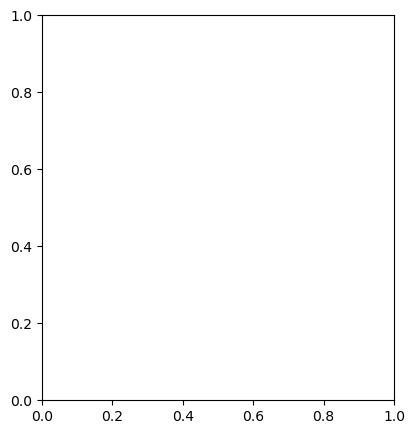

In [90]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train")
plt.plot(validation_losses, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train")
plt.plot(validation_accs, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend()
plt.show()

In [ ]:
torch.save(model.state_dict(), "model.pth")

In [ ]:
model.load_state_dict(torch.load("model.pth"))

/var/folders/s2/kqf29pt97w527q67cq0htzc80000gn/T/ipykernel_18400/1722216506.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pth")

<All keys matched successfully>

In [ ]:
def predict(model, dataloader):
    model.eval()  # 평가 모드로 전환
    all_preds = []

    with torch.no_grad():  # 그래디언트 계산 비활성화
        for data, _ in dataloader:
            data = data.to(device)  # 데이터를 장치로 이동
            
            # 모델 예측
            outputs = model(data)
            preds = outputs.argmax(dim=1)
            
            # 예측값을 리스트에 추가
            all_preds.extend(preds.cpu().numpy())

    return all_preds

In [ ]:
preds = predict(model, test_dataloader)

In [ ]:
confusion_matrix(tst_y, preds)

array([[44,  0,  1, ...,  0,  1,  0],
       [ 3, 29,  0, ...,  0,  1,  2],
       [ 0,  0, 14, ...,  0,  4,  0],
       ...,
       [ 0,  1,  2, ..., 22,  0,  0],
       [ 1,  0,  7, ...,  0, 18,  0],
       [ 1,  0,  4, ...,  0,  1, 11]])

In [ ]:
classification_report(tst_y, preds)

'              precision    recall  f1-score   support\n\n           0       0.53      0.59      0.56        75\n           1       0.45      0.34      0.39        85\n           2       0.09      0.27      0.13        51\n           3       0.25      0.13      0.17        71\n           4       0.15      0.14      0.14        80\n           5       0.28      0.43      0.34        67\n           6       0.43      0.16      0.23        75\n           7       0.30      0.30      0.30        64\n           8       0.55      0.49      0.52        76\n           9       0.47      0.40      0.43        60\n          10       0.41      0.26      0.32        74\n          11       0.18      0.22      0.20        91\n          12       0.30      0.30      0.30        76\n          13       0.42      0.44      0.43        84\n          14       0.41      0.16      0.23        77\n          15       0.48      0.26      0.33        98\n          16       0.52      0.31      0.39        77\n       

In [ ]:
accuracy_score(tst_y, preds)

0.3641333333333333

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

print(f1_score(tst_y, preds, average="macro"))
print(precision_score(tst_y, preds, average="macro"))
print(recall_score(tst_y, preds, average="macro"))

0.35995818427350657
0.3912347075706643
0.3621484283751773
